In [1]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import main_sp
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning) 
warnings.simplefilter(action='ignore',category=RuntimeWarning) 
warnings.simplefilter(action='ignore',category=DeprecationWarning)

In [2]:
def check_folders(foldername='Input'):
    """
    Checks if a folder exists, renames it if it does, and creates necessary subdirectories.
    This function performs the following steps:
    1. Checks if a directory with the specified name exists.
    2. If the directory exists, it attempts to rename it by appending '_CAREFUL_PREVIOUS_INPUT' to the name.
       - If renaming fails due to an OSError, it prints an error message and raises the exception.
    3. Creates a new directory with the specified name.
    4. Creates a subdirectory named 'StatesMatrices' within the newly created directory.
    Args:
        foldername (str): The name of the folder to check and create. Defaults to 'Input'.
    Raises:
        OSError: If renaming the existing directory fails.
    """

    if os.path.isdir(foldername):
        try:
            os.rename(foldername,f'{foldername}_CAREFUL_PREVIOUS_INPUT')
        except OSError:
            print('TOO MANY CASES WITH THE SAME NAME')
            raise
    os.makedirs(foldername, exist_ok=True)
    os.makedirs(f'./{foldername}/StatesMatrices', exist_ok=True)

def download_nwk(lat=38.435220,lon=141.303816,radius=1000, show=True, save=True, foldername='Input'):
    """
    Downloads a network graph from OpenStreetMap based on a specified location and radius, 
    and optionally plots and saves the graph.

    Parameters:
    lat (float): Latitude of the center point. Default is 38.435220.
    lon (float): Longitude of the center point. Default is 141.303816.
    radius (int): Radius in meters to define the area for the network graph. Default is 1000.
    show (bool): Whether to display the plot. Default is True.
    save (bool): Whether to save the plot as an image file. Default is True.
    foldername (str): Name of the folder to save the plot image. Default is 'Input'.

    Returns:
    networkx.Graph: An undirected, projected graph of the specified area.
    """

    G = ox.graph_from_point(center_point=(lat,lon), network_type='all', dist=radius, simplify=True)
    fig, ax = ox.plot_graph(G,node_color='blue',bgcolor='white', show=show, save=save, filepath=f'./{foldername}/nwk_simple.png')
    G_proj = ox.project_graph(G)
    G_und = G_proj.to_undirected()
    return G_und

def unpack_columns(df, c):
    """
    Unpacks dictionaries stored in a specified column of a DataFrame into separate columns.
    Args:
        df (pandas.DataFrame): The DataFrame containing the column with dictionaries.
        c (str): The name of the column containing dictionaries to unpack.
    Returns:
        pandas.DataFrame: The DataFrame with new columns added, each corresponding to a key in the dictionaries.
    """
    keys = []
    for row in df.iterrows():
        keys.append(row[1][c].keys())
    keys = list(set([item for sublist in keys for item in sublist]))

    for key in keys:
        df[key] = df[c].apply(lambda x: x.get(key))
    return df

def get_nodedb(G,evacnodes=[0],foldername='Input'):
    """
    Generates a node database from a graph and saves it as a CSV file.
    Parameters:
    G (networkx.Graph): The input graph from which to generate the node database.
    evacnodes (list, optional): List of node IDs that are evacuation nodes. Default is [0].
    foldername (str, optional): The name of the folder where the CSV file will be saved. Default is 'Input'.
    Returns:
    pandas.DataFrame: A DataFrame containing the node database with columns:
                        '#number', 'Coord_x', 'Coord_y', 'evacuation', 'reward'.
    """
    Gdfn = pd.DataFrame(G.nodes(data=True))
    Gdfn = unpack_columns(Gdfn,1)      
    Gdfn.drop([1,'street_count','highway', 'lat', 'lon'],axis=1,inplace=True)
    Gdfn.rename(columns={0:'osmid', 'x':'Coord_x', 'y': 'Coord_y'},inplace=True)
    Gdfn['evacuation'] = 0
    for node in evacnodes:
        Gdfn.loc[Gdfn['osmid'] == node,'evacuation'] = 1
        print(f'Node {node} is an evacuation node')
    Gdfn['reward'] = 1
    Gdfn['#number'] = Gdfn.index
    Gdfn.index = Gdfn['osmid']
    Gdfn = Gdfn[['#number', 'Coord_x','Coord_y','evacuation','reward']]
    Gdfn.to_csv(f'./{foldername}/nodes.csv',index=False)
    return Gdfn

def get_edgedb(G, Gdfn, foldername='Input'):
    """
    Processes the edges of a graph and saves the resulting DataFrame to a CSV file.
    Parameters:
    G (networkx.Graph): The input graph.
    Gdfn (pandas.DataFrame): The node database DataFrame.
    foldername (str): The name of the folder where the CSV file will be saved. Default is 'Input'.
    Returns:
    pandas.DataFrame: A DataFrame containing the processed edges of the graph with columns:
        - '#number': The index of the edge.
        - 'Node1': The starting node of the edge.
        - 'Node2': The ending node of the edge.
        - 'Length': The length of the edge.
        - 'Width': The width of the edge (default is 3).
    """
    Gdfe = pd.DataFrame(G.edges(data=True))
    Gdfe = unpack_columns(Gdfe,2)
    for row in Gdfe.iterrows():
        #erase loop edges
        if row[1][0] == row[1][1]:# or row[1][0] in row[1][2]['osmid'] or row[1][1] in row[1][2]['osmid']:
            Gdfe.drop(row[0],inplace=True)

        #erase edges with length 0
        if int(row[1][2]['length']) == 0:
            Gdfe.drop(row[0],inplace=True)
        
        #replace list elements with first element
        Gdfe['osmid'] = Gdfe['osmid'].apply(lambda x: x[0] if type(x) is list else x)
   
    Gdfe.reset_index(drop=True,inplace=True)
    Gdfe['#number'] = Gdfe.index.astype(np.int64)
    Gdfe['Node1'] = Gdfe[0].map(Gdfn['#number']).astype(np.int64)
    Gdfe['Node2'] = Gdfe[1].map(Gdfn['#number']).astype(np.int64)
    Gdfe['Length'] = Gdfe['length'].astype(np.int64)
    Gdfe['Width'] = 3
    Gdfe = Gdfe[['#number', 'Node1', 'Node2', 'Length', 'Width']]
    Gdfe.to_csv(f'./{foldername}/edges.csv',index=False)
    return Gdfe

def get_fake_population(times=1,foldername='Input'):
    """
    Generates a fake population dataset based on the nodes information and saves it to a CSV file.

    Parameters:
    times (int): The multiplier for the number of times to replicate the nodes data. Default is 1.
    foldername (str): The name of the folder where the input nodes.csv file is located and where the output population.csv file will be saved. Default is 'Input'.

    Returns:
    None: The function saves the generated population data to a CSV file named 'population.csv' in the specified folder.
    """

    df = pd.read_csv(f'./{foldername}/nodes.csv')    
    pop = pd.DataFrame()
    pop['#age'] = np.zeros(df.shape[0] * times)
    pop['Gender'] = np.zeros(df.shape[0] * times)
    pop['Hh Type'] = np.zeros(df.shape[0] * times)
    pop['Hh Id'] = np.zeros(df.shape[0] * times)
    pop['Node'] = list(df['#number']) * times
    pop.sort_values(by='Node')
    pop.reset_index()
    pop.to_csv(f'./{foldername}/population.csv', index=False)
    
def get_actionsdb_transitionsdb(foldername='Input'):
    """
    Generates and saves actions, transitions, probabilities, and rewards databases from input node and edge data.
    Parameters:
    foldername (str): The name of the folder containing the input CSV files 'nodes.csv' and 'edges.csv'. Default is 'Input'.
    The function performs the following steps:
    1. Loads node and edge data from CSV files located in the specified folder.
    2. Initializes actions, transitions, probabilities, and rewards databases with zeros.
    3. Iterates over each node to populate the databases based on the node and edge data.
    4. Saves the populated actions and transitions databases to CSV files in the specified folder.
    The input CSV files should have the following structure:
    - nodes.csv: Columns should include node ID and other relevant attributes.
    - edges.csv: Columns should include edge ID, source node ID, target node ID, and edge weight.
    The output CSV files will have the following structure:
    - actionsdb.csv: Columns include node ID, number of actions, and action details.
    - transitionsdb.csv: Columns include node ID, number of transitions, and transition details.
    """

    nodesdb = np.loadtxt(f"./{foldername}/nodes.csv", delimiter=',', skiprows=1)
    linksdb = np.loadtxt(f"./{foldername}/edges.csv", delimiter=',', skiprows=1)
    numNodes = nodesdb.shape[0]
    numLinks = linksdb.shape[0]
    
    actionsdb = np.zeros((numNodes, 12), dtype=np.int32)
    transitionsdb = np.zeros((numNodes, 12), dtype=np.int32)
    probdb = np.zeros((numNodes, 12), dtype=np.int32) 
    rewarddb = np.zeros((numNodes, 12), dtype=np.int32) 
    
    for i in range(numNodes):
        actionsdb[i,0] = nodesdb[i,0]
        transitionsdb[i,0] = nodesdb[i,0]
        rewarddb[i,0] = nodesdb[i,0]
        
        if nodesdb[i,3]:
            actionsdb[i,1] = 1
            actionsdb[i,2] = -1
            transitionsdb[i,1] = 1
            transitionsdb[i,2] = actionsdb[i,0]
            rewarddb[i,1] = 1
            rewarddb[i,2] = 0
            continue
            
        tmpLinksdb1 = linksdb[linksdb[:,1] == nodesdb[i,0]]
        tmpLinksdb2 = linksdb[linksdb[:,2] == nodesdb[i,0]]
        numlinks1 = tmpLinksdb1.shape[0]
        numlinks2 = tmpLinksdb2.shape[0]
        
        actionsdb[i,1] = numlinks1 + numlinks2
        transitionsdb[i,1] = numlinks1 + numlinks2
        rewarddb[i,1] = numlinks1 + numlinks2
        
        if numlinks1:
            actionsdb[i, 2: 2+numlinks1] = tmpLinksdb1[:,0]
            transitionsdb[i,2:2 + numlinks1] = tmpLinksdb1[:,2]
            rewarddb[i, 2:2+numlinks1] = -tmpLinksdb1[:,3]
        
        if numlinks2:
            actionsdb[i, 2+numlinks1 : 2+numlinks1+numlinks2] = tmpLinksdb2[:,0]
            transitionsdb[i, 2+numlinks1 : 2+numlinks1+numlinks2] = tmpLinksdb2[:,1]
            rewarddb[i, 2+numlinks1 : 2+numlinks1+numlinks2] = -tmpLinksdb2[:,3]

    ind = np.argmax(actionsdb[:,1])
    probdb[:,0:2] = actionsdb[:,0:2]
#    rewarddb[:,0:2] = actionsdb[:,0:2]
    
    for i in range(numNodes):
        numActions = actionsdb[i,1]
        if numActions:
            probdb[i,2:2+numActions] = np.ones(numActions)
    
    np.savetxt(f'./{foldername}/actionsdb.csv', actionsdb, delimiter=',', fmt='%d')
    np.savetxt(f'./{foldername}/transitionsdb.csv', transitionsdb, delimiter=',', fmt='%d')
    
    
def get_shortpath_file(foldername):
    """
    Generates a CSV file containing the next node in the shortest path to the nearest shelter for each node in a graph.
    Parameters:
    foldername (str): The name of the folder containing the 'nodes.csv' and 'edges.csv' files.
    The function performs the following steps:
    1. Reads node and edge data from CSV files located in the specified folder.
    2. Creates a graph using the NetworkX library and adds nodes and edges to it.
    3. Identifies shelter nodes (nodes with an evacuation value of 1).
    4. Calculates the shortest path lengths from each node to each shelter.
    5. Determines the closest shelter for each node.
    6. Calculates the next node in the shortest path to the closest shelter for each node.
    7. Saves the results to a CSV file named 'nextnode.csv' in the specified folder.
    The input CSV files should have the following structure:
    - nodes.csv: Columns ["#number", "Coord_x", "Coord_y", "Evacuation", "Reward"]
    - edges.csv: Columns ["#number", "Node1", "Node2", "Length", "Width"]
    The output CSV file 'nextnode.csv' will contain the following columns:
    - #number: The node number.
    - nextnode: The next node in the shortest path to the nearest shelter.
    """
    #create a graph
    G = nx.Graph()

    #read data
    Nodesdf = pd.read_csv(f'./{foldername}/nodes.csv',names=["#number","Coord_x","Coord_y","Evacuation","Reward"],skiprows=1)
    Edgesdf = pd.read_csv(f'./{foldername}/edges.csv',names=["#number","Node1","Node2","Length",'Width'],skiprows=1)

    #add nodes to graph
    for i,row in Nodesdf.iterrows():
        # G.add_node(row[0],pos=(row[1],row[2]),ntype=row[3])
        G.add_node(row[0],x=row[1],y=row[2],ntype=row[3])

    #add edges to graph
    for i,row in Edgesdf.iterrows():
        G.add_edge(row[1],row[2],length=row[3])

    # numberOfNodes = G.number_of_nodes()
    # numberOfEdges = G.number_of_edges()
    # numberOfShelters = Sheltersdf.shape[0]
    # print(f'Number of nodes: {numberOfNodes}')
    # print(f'Number of edges: {numberOfEdges}')
    # print(f'Number of shelters: {numberOfShelters}')
    
    #set graph crs
    G.graph['crs'] = {'init': 'epsg:4612'}
    # plot_graph(G)
    # deadends = list(nx.isolates(G))
    # G.remove_nodes_from(deadends)
    # for i, row in Nodesdf.iterrows():
    #     if row[0] in deadends:
    #         Nodesdf.drop(row[0],inplace=True)
    #         Edgesdf = Edgesdf[~Edgesdf['Node1'].isin(deadends)]
    #         Edgesdf = Edgesdf[~Edgesdf['Node2'].isin(deadends)]
    #         continue
    
    # Nodesdf.reset_index(drop=True,inplace=True)
    # Edgesdf.reset_index(drop=True,inplace=True)
    
    Sheltersdf = Nodesdf[Nodesdf["Evacuation"] == 1]
    #calculate shortest paths lengths to each shelter and add to DF
    for i,shrow in Sheltersdf.iterrows():
        lsh = []
        for j,nrow in Nodesdf.iterrows():
            try:
                lsh.append(nx.shortest_path_length(G,source=nrow[0],target=shrow[0],weight='Length'))
            except:# nx.NetworkXNoPath:
                lsh.append(1.0e+10)
        Nodesdf[str(i)]=lsh
        lsh = []
    
    #calculate from each node its closest shelter
    ShelterColumnsSeries = []
    for i, nrow in Nodesdf.iterrows():
        ShelterColumnsSeries.append(nrow[5:].idxmin())
    Nodesdf['shelter']= ShelterColumnsSeries

    #calculate shortest path from each node to corresponding shelter
    ln = []
    for i, nrow in Nodesdf.iterrows():
        try:
            if int(nrow[0]) != int(nrow.shelter):
                ln.append(nx.shortest_path(G,int(nrow[0]),int(nrow.shelter))[1])
            else:
                ln.append(int(nrow[0]))
        except:# nx.NetworkXNoPath:
            ln.append(int(-9999))
    Nodesdf['nextnode']=ln

    data = Nodesdf[['#number','nextnode']]
    data.to_csv(f'./{foldername}/nextnode.csv',index=False)
    
    # Nodesdf.to_csv(f'./{foldername}/nodes.csv',index=False)
    # Edgesdf.to_csv(f'./{foldername}/edges.csv',index=False)

def plot_graph(G):
    """
    Plots a graph using matplotlib from a NetworkX graph object.

    This function converts a MultiGraph to a simple Graph, extracts node coordinates,
    and plots the nodes and edges of the graph.

    Parameters:
    G (networkx.Graph or networkx.MultiGraph): The input graph to be plotted.

    Returns:
    None
    """

    #convert multigraph to graph
    Gnew = nx.Graph(G)
    #to plot an undirected graph
    Gnew_nodes = pd.DataFrame(Gnew.nodes(data=True))
    print(Gnew_nodes.head())
    Gnew_nodes['y']=Gnew_nodes[1].apply(lambda x: x['y']).astype(float)
    Gnew_nodes['x']=Gnew_nodes[1].apply(lambda x: x['x']).astype(float)
    Gnew_nodes['osmid']=Gnew_nodes[0].astype(int)
    Gnew_nodes.drop(1,axis=1,inplace=True)
    Gnew_nodes.index = Gnew_nodes[0]
    # plot a network graph from a pandas dataframe Gnew_nodes with x and y coordinates using matplotlib
    plt.figure(figsize=(10,10))
    plt.scatter(Gnew_nodes['x'],Gnew_nodes['y'],s=3, c='b')
    # add the edges of the graph
    for edge in Gnew.edges():
        x = [Gnew_nodes.loc[edge[0]]['x'],Gnew_nodes.loc[edge[1]]['x']]
        y = [Gnew_nodes.loc[edge[0]]['y'],Gnew_nodes.loc[edge[1]]['y']]
        plt.plot(x,y,'k-',linewidth=0.5)
    plt.show()
    
#erase folders
def erase_folders(case):
    """
    Deletes specified folders related to a given case.

    This function attempts to remove two directories:
    1. A directory named after the provided case.
    2. A directory named after the provided case with the suffix '_CAREFUL_PREVIOUS_INPUT'.

    If the directories do not exist or cannot be removed, the function will silently fail without raising an exception.

    Parameters:
    case (str): The name of the case used to identify the directories to be removed.

    Returns:
    None
    """

    try:
        os.system(f'rm -r ./{case}')
    except:
        pass
    try:
        os.system(f'rm -r ./{case}_CAREFUL_PREVIOUS_INPUT')
    except:
        pass
    

In [3]:
areas = {
    'ishinomaki': (38.435220,141.303816),
    'otaru' : (43.197519, 140.993391),
    'kochi' : (33.50505, 133.53161),
    'noto' : (37.39048, 136.90287),
    'sumatra' : (5.55326, 95.29700),
    'peru' : (-12.07860, -77.08124)
}

rm: ./ishinomaki_CAREFUL_PREVIOUS_INPUT: No such file or directory


Node 8334414743 is an evacuation node


 ***** Simu 0 (t= 0.00)*****
survived pedestrians: 4


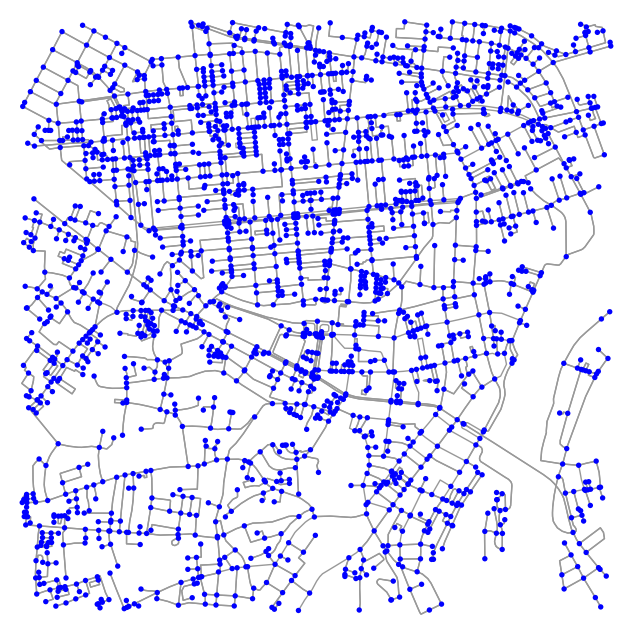

In [4]:
case = 'ishinomaki' #use names in 'areas' dictionary
erase_folders(case)
#prepare folders
check_folders(foldername=case)
#download network
G = download_nwk(areas[case][0],areas[case][1],1000,show=False, save=True, foldername=case)
#set seed for replication
np.random.seed(10)
#choose randomnly 4 nodes for evacuation
evacnodes = np.random.choice(G.nodes, size=1)
#prepare databases
Gdfn = get_nodedb(G, evacnodes=evacnodes, foldername=case)
Gdfe = get_edgedb(G, Gdfn, foldername=case)
get_shortpath_file(foldername=case)
get_fake_population(times=1, foldername=case)
get_actionsdb_transitionsdb(foldername=case)
# run evacuation model (RL)
main_sp.run(numSim0=0, numBlocks=1, simPerBlock=20, simulTime=10*60, foldername=case)

In [5]:
Gdfe.head()

,#number,Node1,Node2,Length,Width
0,0,0,1,7,3
1,1,1,78,15,3
2,2,1,58,36,3
3,3,1,79,11,3
4,4,2,3,7,3


In [6]:
Gdfn.head()

,#number,Coord_x,Coord_y,evacuation,reward
osmid,,,,,
461190492,0,526533.110853,4.254096e+06,0,1
918333243,1,526531.880015,4.254088e+06,0,1
461190495,2,526508.142763,4.253945e+06,0,1
2166919145,3,526501.559476,4.253948e+06,0,1
2166919097,4,526519.745348,4.253938e+06,0,1


In [7]:
Gdfe['Node1'].map(Gdfn['#number'])

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
2847   NaN
2848   NaN
2849   NaN
2850   NaN
2851   NaN
Name: Node1, Length: 2852, dtype: float64

In [8]:
Gdfn.head()

,#number,Coord_x,Coord_y,evacuation,reward
osmid,,,,,
461190492,0,526533.110853,4.254096e+06,0,1
918333243,1,526531.880015,4.254088e+06,0,1
461190495,2,526508.142763,4.253945e+06,0,1
2166919145,3,526501.559476,4.253948e+06,0,1
2166919097,4,526519.745348,4.253938e+06,0,1


In [9]:
Gdfe = pd.DataFrame(G.edges(data=True))
Gdfe.head()

,0,1,2
0,461190492,918333243,"{'osmid': 1068318003, 'highway': 'service', 'a..."
1,461190492,461190492,"{'osmid': 429699718, 'highway': 'service', 'ac..."
2,918333243,2163744788,"{'osmid': 38846004, 'highway': 'tertiary', 'on..."
3,918333243,461226859,"{'osmid': 38846004, 'highway': 'tertiary', 'on..."
4,918333243,8422136403,"{'osmid': 572788623, 'highway': 'primary', 'on..."


In [10]:
#find all keys in dictionaries at column 1
keys = []
for row in Gdfe.iterrows():
    keys.append(row[1][2].keys())
keys = list(set([item for sublist in keys for item in sublist]))
keys

['service',
 'reversed',
 'ref',
 'oneway',
 'lanes',
 'geometry',
 'bridge',
 'access',
 'name',
 'highway',
 'tunnel',
 'osmid',
 'maxspeed',
 'length']

In [11]:
for key in keys:
    Gdfe[key] = Gdfe[2].apply(lambda x: x.get(key))

In [12]:
Gdfe.head()

,0,1,2,service,reversed,ref,oneway,lanes,geometry,bridge,access,name,highway,tunnel,osmid,maxspeed,length
0,461190492,918333243,"{'osmid': 1068318003, 'highway': 'service', 'a...",None,False,None,False,None,None,None,no,None,service,None,1068318003,None,7.983
1,461190492,461190492,"{'osmid': 429699718, 'highway': 'service', 'ac...",None,False,None,True,None,LINESTRING (526533.1108533128 4254096.32888824...,None,no,None,service,None,429699718,None,94.152
2,918333243,2163744788,"{'osmid': 38846004, 'highway': 'tertiary', 'on...",None,True,None,False,2,None,None,None,None,tertiary,None,38846004,None,15.343
3,918333243,461226859,"{'osmid': 38846004, 'highway': 'tertiary', 'on...",None,False,None,False,2,None,None,None,None,tertiary,None,38846004,None,36.043
4,918333243,8422136403,"{'osmid': 572788623, 'highway': 'primary', 'on...",None,True,6,False,None,None,None,None,石巻停車場線,primary,None,572788623,None,11.186


In [13]:
def get_edgedb(Gdfe, foldername='Input'):
    for row in Gdfe.iterrows():
        #erase loop edges
        if row[1][0] == row[1][1]:# or row[1][0] in row[1][2]['osmid'] or row[1][1] in row[1][2]['osmid']:
            Gdfe.drop(row[0],inplace=True)

        #erase edges with length 0
        if row[1][2]['length'] == 0:
            Gdfe.drop(row[0],inplace=True)
        
        #replace list elements with first element
        Gdfe['osmid'] = Gdfe['osmid'].apply(lambda x: x[0] if type(x) is list else x)

    Gdfe.reset_index(drop=True,inplace=True)
    Gdfe['#number'] = Gdfe.index.astype(np.int32)
    Gdfe['Node1'] = Gdfe[0].astype(np.int32)
    Gdfe['Node2'] = Gdfe[1].astype(np.int32)
    Gdfe['Length'] = Gdfe['length'].astype(np.int32)
    Gdfe['Width'] = 3
    Gdfe = Gdfe[['#number', 'Node1', 'Node2', 'Length', 'Width']]
    Gdfe.to_csv(f'./{foldername}/edges.csv',index=False)
    return Gdfe

            0                                                  1
0   461190492  {'y': 4254096.328888247, 'x': 526533.110853312...
1   918333243  {'y': 4254088.457631121, 'x': 526531.880015187...
2   461190495  {'y': 4253944.728143291, 'x': 526508.142762510...
3  2166919145  {'y': 4253948.112982299, 'x': 526501.559476008...
4  2166919097  {'y': 4253938.474846171, 'x': 526519.745348098...


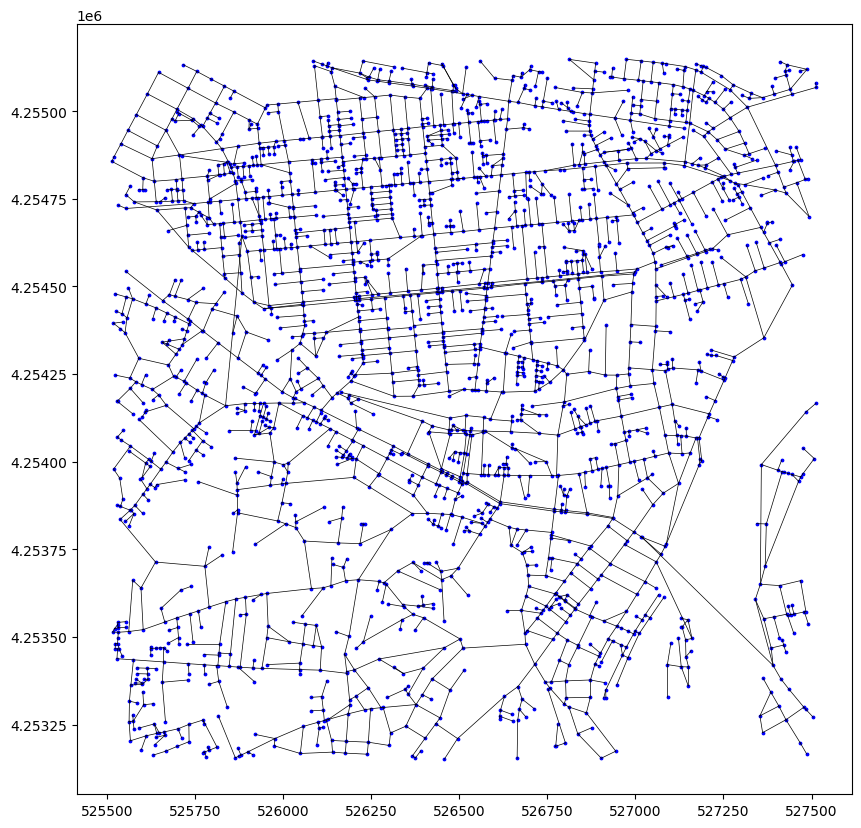

In [14]:
plot_graph(G)

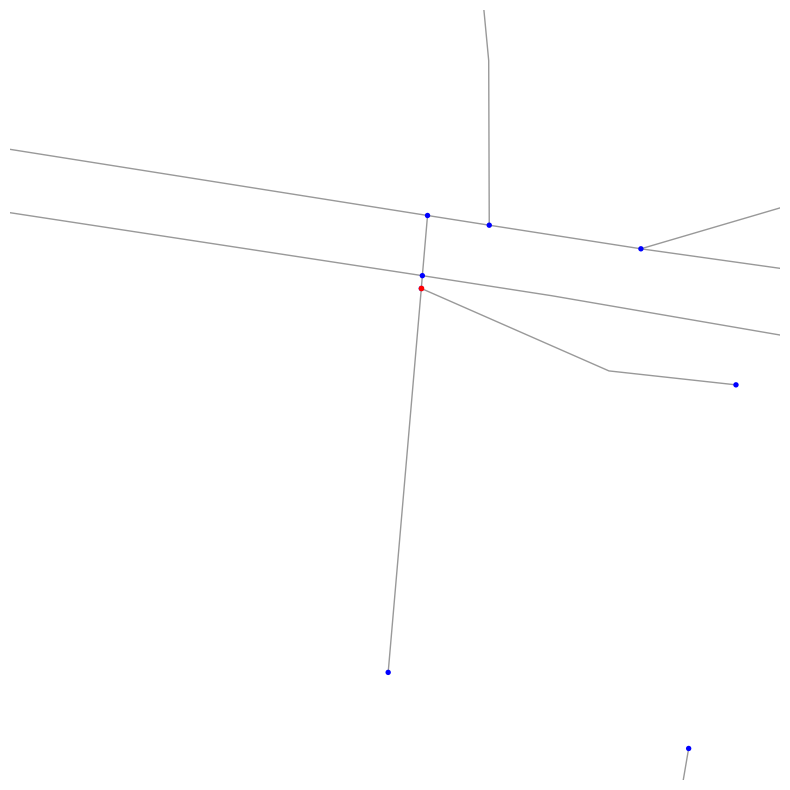

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [15]:
#plot the graph G with one node labeled
id = 2347
ms = 3
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(Gdfn.loc[Gdfn['#number']==id,'Coord_x'],Gdfn.loc[Gdfn['#number']==id,'Coord_y'],'ro', markersize=ms)
ox.plot_graph(G, ax=ax, node_color='blue', bgcolor='white', bbox=(4255050, 4255100, 526400, 526450))


In [16]:
Gdfn = pd.DataFrame(G.nodes(data=True))
Gdfn.head()

,0,1
0,461190492,"{'y': 4254096.328888247, 'x': 526533.110853312..."
1,918333243,"{'y': 4254088.457631121, 'x': 526531.880015187..."
2,461190495,"{'y': 4253944.728143291, 'x': 526508.142762510..."
3,2166919145,"{'y': 4253948.112982299, 'x': 526501.559476008..."
4,2166919097,"{'y': 4253938.474846171, 'x': 526519.745348098..."


In [17]:
Gdfn.loc[Gdfn[0]==8422014609]

,0,1
1365,8422014609,"{'y': 4253252.211138032, 'x': 525775.879682128..."


In [18]:
Gdfe = pd.DataFrame(G.edges(data=True))
Gdfe.head()

,0,1,2
0,461190492,918333243,"{'osmid': 1068318003, 'highway': 'service', 'a..."
1,461190492,461190492,"{'osmid': 429699718, 'highway': 'service', 'ac..."
2,918333243,2163744788,"{'osmid': 38846004, 'highway': 'tertiary', 'on..."
3,918333243,461226859,"{'osmid': 38846004, 'highway': 'tertiary', 'on..."
4,918333243,8422136403,"{'osmid': 572788623, 'highway': 'primary', 'on..."


In [19]:
Gdfe.loc[Gdfe[1]==8422014609]

,0,1,2
1988,8422014613,8422014609,"{'osmid': 906977988, 'highway': 'service', 'on..."
2205,8422014609,8422014609,"{'osmid': 906977988, 'highway': 'service', 'on..."
2206,8422014609,8422014609,"{'osmid': 906977988, 'highway': 'service', 'on..."
